# Test IIR coefficients determination

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.signal import lfilter, lfilter_zi
from scipy.optimize import least_squares, minimize, Bounds
from cryoscope_scripts import load_cryoscope_data
from IIR import (
    step,
    inverse_model_IIR,
    residuals_inverse_IIR,
    multi_exponential_IIR,
    residuals_multi_exponential,
)

from numpy import convolve

from qibocal.protocols.two_qubit_interaction.cryoscope import (
    _fit,
    _plot,
    CryoscopeData,
    CryoscopeType,
)

[Qibo 0.2.12|INFO|2024-12-16 09:36:23]: Loading platform dummy
[Qibo 0.2.12|INFO|2024-12-16 09:36:23]: Loading platform dummy


In [2]:
data_path = Path.cwd().parent / "cryo_material" / "long_acquisition" / "data" / "cryoscope-0"
data_json = data_path / "data.json"

with open(data_json, "rb") as file:
    data = json.load(file)

flux_pulse_amplitude = data["\"flux_pulse_amplitude\""]
cryoscope_data = load_cryoscope_data(data_path / "data.npz",0.5)

In [3]:
cryoscope_results = _fit(cryoscope_data)

In [4]:
t = np.arange(0,89,1)
start = 0
ideal_signal = step(t, start)

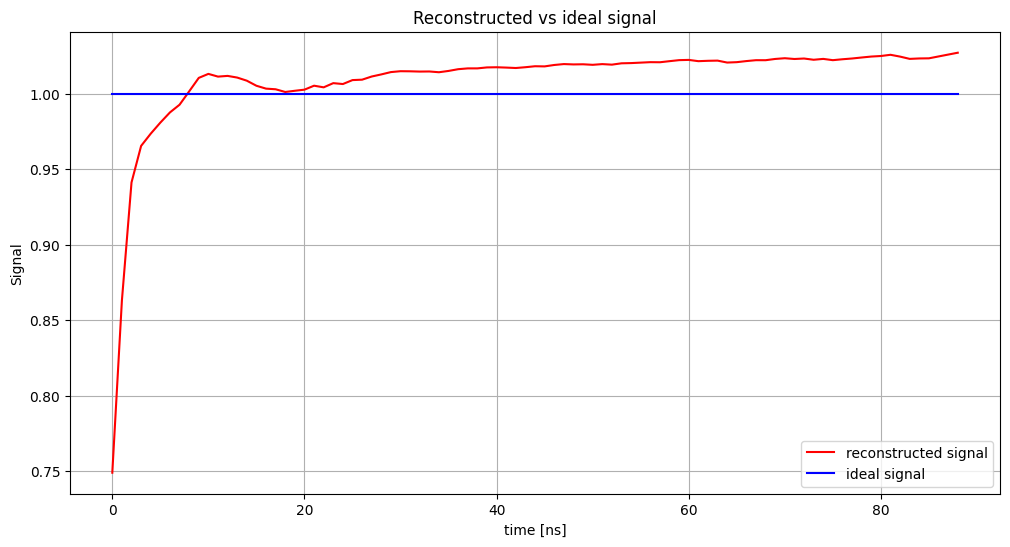

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(cryoscope_results.step_response["D1"][10:], color="red", label="reconstructed signal")
plt.plot(ideal_signal, color="blue", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Reconstructed vs ideal signal")
plt.legend()
plt.grid()
plt.show()

**Testing parameters conversion for a single fit**

In [6]:
# single filter application
initial_guess = [1, 1, 1]
step_response = cryoscope_results.step_response["D1"][10:]
result = least_squares(
    residuals_inverse_IIR, initial_guess, args=(t, start, step_response)
)
print(result)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-5.680e-03  3.923e-03 ...  8.997e-03  1.021e-02]
           x: [ 1.017e+00  1.932e+00 -2.592e-01]
        cost: 0.002427440988454036
         jac: [[-9.779e-01  0.000e+00 -1.342e+00]
               [-9.873e-01  4.913e-02 -7.077e-01]
               ...
               [-9.923e-01  0.000e+00 -0.000e+00]
               [-9.935e-01  0.000e+00 -0.000e+00]]
        grad: [-5.866e-10 -2.401e-08 -2.223e-08]
  optimality: 2.40122010032812e-08
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 12
        njev: 11


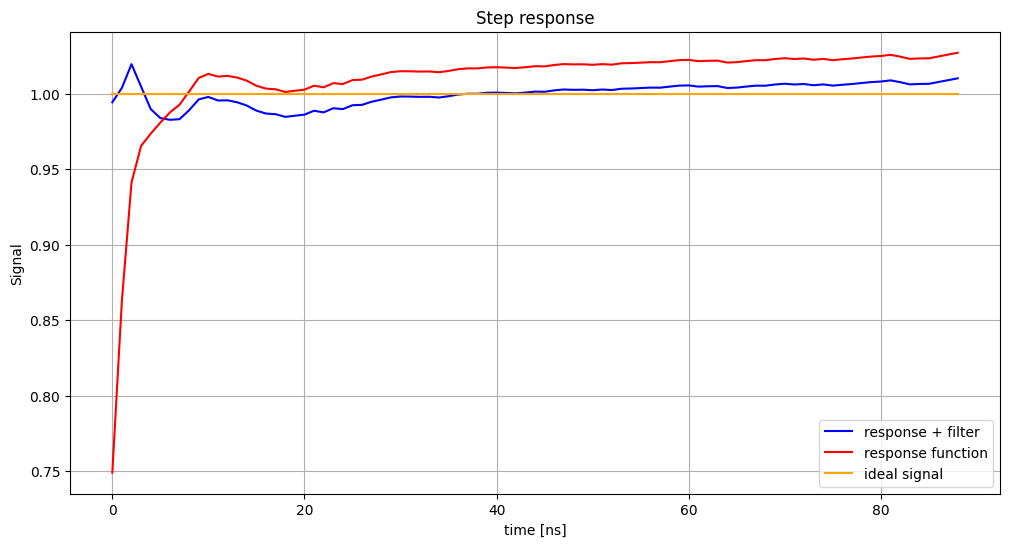

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(
    t,
    inverse_model_IIR(result.x, t, start, step_response),
    color="blue",
    label="response + filter",
)
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

In [8]:
print(result.x)

[ 1.01678789  1.9324137  -0.25922678]


In [9]:
def single_exp_params(params, sampling_rate):
    g, tau, A = params
    alpha = 1 - np.exp(-1/(sampling_rate*tau*(1+A)))
    k = A/((1+A)*(1-alpha)) if A < 0 else A/(1+A-alpha)
    b0 = 1 - k + k*alpha
    b1 = - (1-k)*(1-alpha)
    a0 = 1
    a1 = -(1-alpha)

    a = np.array([a0, a1])
    b = np.array([b0, b1])
    return a, b

In [10]:
a, b = single_exp_params(result.x, 1)

**Test without computing zi**

In [11]:
filtered_response = lfilter(b, a, step_response)

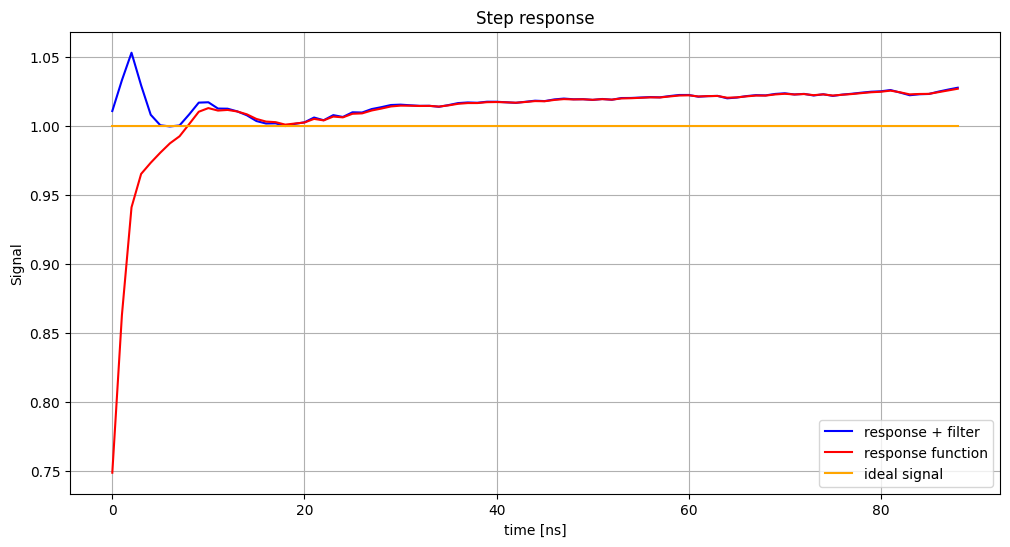

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(
    filtered_response,
    color="blue",
    label="response + filter",
)
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

**Test computing zi**

In [13]:
zi = lfilter_zi(b,a)*step_response[0]
filtered_response, _ = lfilter(b, a, step_response, zi=zi)

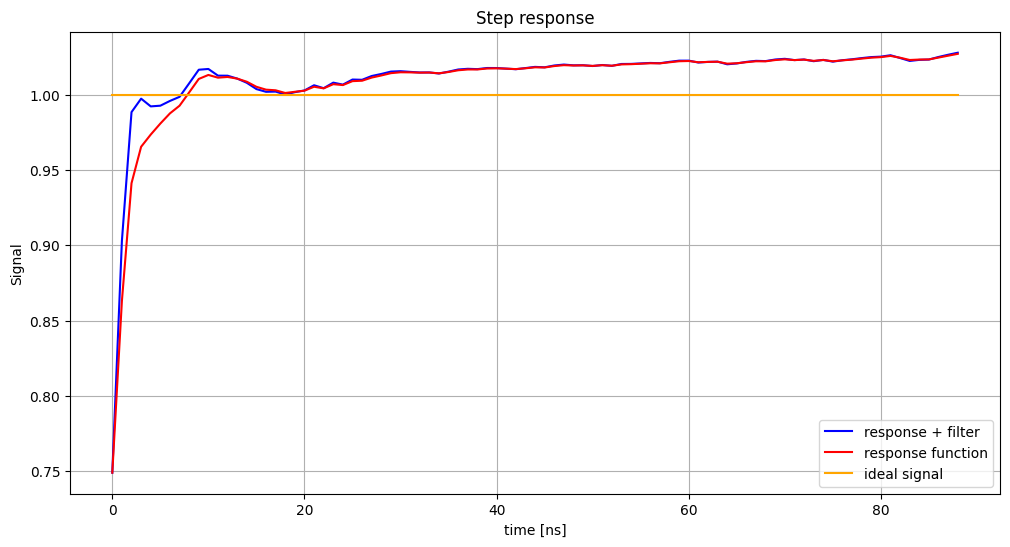

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(
    filtered_response,
    color="blue",
    label="response + filter",
)
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

**Code for filter application iteration**

In [15]:
init_guess = [1, 1, 1]
results = []
responses = []

for i in range(5):
    result = least_squares(
        residuals_inverse_IIR, initial_guess, args=(t, start, step_response)
    )
    results.append(result)
    step_response = inverse_model_IIR(result.x, t, start, step_response)
    responses.append(step_response)

/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:22: RuntimeWarning: overflow encountered in exp
  return data / (g * (1 + A * np.exp(-(t - start) / tau)))


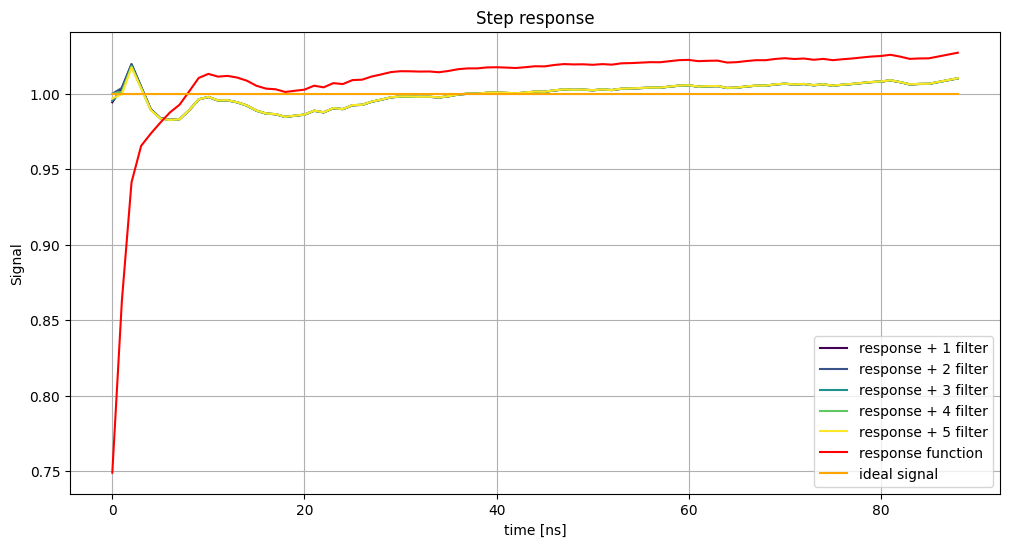

In [16]:
step_response = cryoscope_results.step_response["D1"][10:]
colors = plt.cm.viridis(np.linspace(0, 1, len(responses)))

plt.figure(figsize=(12, 6))

for i, resp in enumerate(responses):
    plt.plot(t, resp, color=colors[i], label=f"response + {i+1} filter")
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

In [17]:
for result in results:
    print(result.x)

[ 1.01678789  1.9324137  -0.25922678]
[ 1.00006418  0.04952302 -0.00574361]
[0.99988383 1.69321143 0.00459878]
[ 1.00005048  0.0249821  -0.0045124 ]
[0.9999222  1.58098523 0.00323959]


In [18]:
b_total = [1]
a_total = [1]

for result in results:
    params = result.x 
    a, b = single_exp_params(params, 1)
    b_total = convolve(b_total, b)  
    a_total = convolve(a_total, a)

print(a_total)
print(b_total)

[ 1.00000000e+00 -1.58512941e+00  8.36686325e-01 -1.47055950e-01
  2.22471627e-10  0.00000000e+00]
[nan nan nan nan nan nan]


/tmp/ipykernel_9435/3310865186.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  k = A/((1+A)*(1-alpha)) if A < 0 else A/(1+A-alpha)
/tmp/ipykernel_9435/3310865186.py:5: RuntimeWarning: invalid value encountered in scalar add
  b0 = 1 - k + k*alpha
/tmp/ipykernel_9435/3310865186.py:6: RuntimeWarning: invalid value encountered in scalar multiply
  b1 = - (1-k)*(1-alpha)


**IIR parameters from multi-epxonential correction**

In [20]:
initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 1]
step_response = cryoscope_results.step_response["D1"][10:]
result = least_squares(
    residuals_multi_exponential, initial_guess, args=(t, start, step_response)
)
print(result)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.506e-03 -9.449e-03 ...  2.156e-03  3.347e-03]
           x: [ 1.008e+00  1.022e+00 -1.714e-01  1.008e+00  8.683e+00
                7.286e-01  1.008e+00  1.128e+01 -4.901e-01]
        cost: 0.00041608155796998256
         jac: [[-9.935e-01  0.000e+00 ...  0.000e+00 -1.964e+00]
               [-9.826e-01  6.529e-02 ...  6.331e-03 -1.644e+00]
               ...
               [-9.941e-01  0.000e+00 ...  1.503e-04 -4.487e-04]
               [-9.953e-01  0.000e+00 ...  1.393e-04 -4.111e-04]]
        grad: [-2.008e-05 -3.711e-10 -4.357e-07 -2.009e-05 -1.417e-07
               -1.554e-06 -2.008e-05  1.285e-07 -3.775e-06]
  optimality: 2.0089379470528968e-05
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
                0.000e+00  0.000e+00  0.000e+00  0.000e+00]
        nfev: 87
        njev: 62


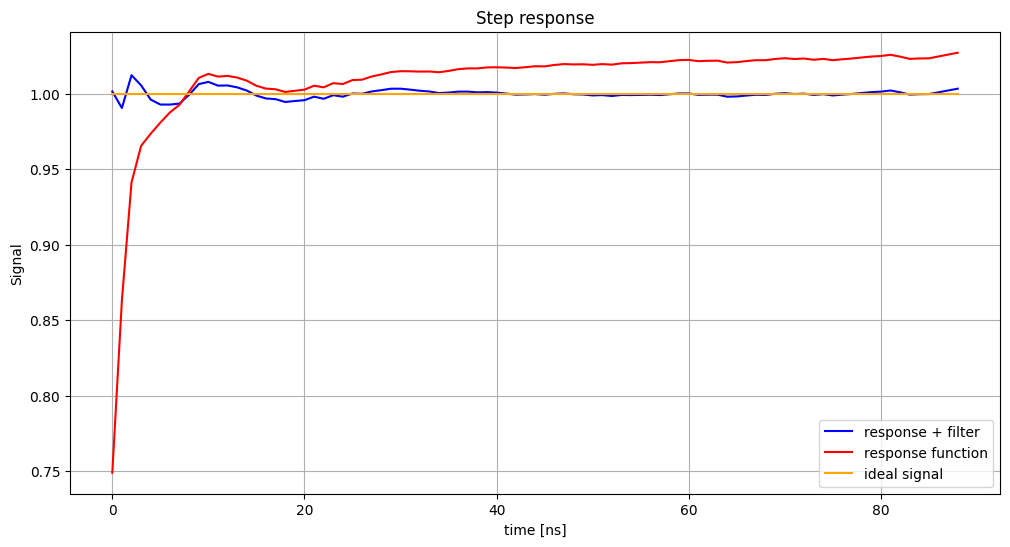

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(
    t,
    multi_exponential_IIR(result.x, t, start, step_response),
    color="blue",
    label="response + filter",
)
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

In [46]:
b_total = [1]
a_total = [1]
all_params = []

i = 0
while i < len(result.x):
    param = list(result.x[i : i + 3])
    all_params.append(param)
    a, b = single_exp_params(param, 1)
    b_total = convolve(b_total, b)
    a_total = convolve(a_total, a)
    i += 3

print(a_total)
print(b_total) 

[ 1.         -2.08299262  1.33151742 -0.2413974 ]
[ 1.39738872 -3.12349415  2.22012227 -0.48688945]


In [48]:
filtered_response = lfilter(b_total, a_total, step_response)

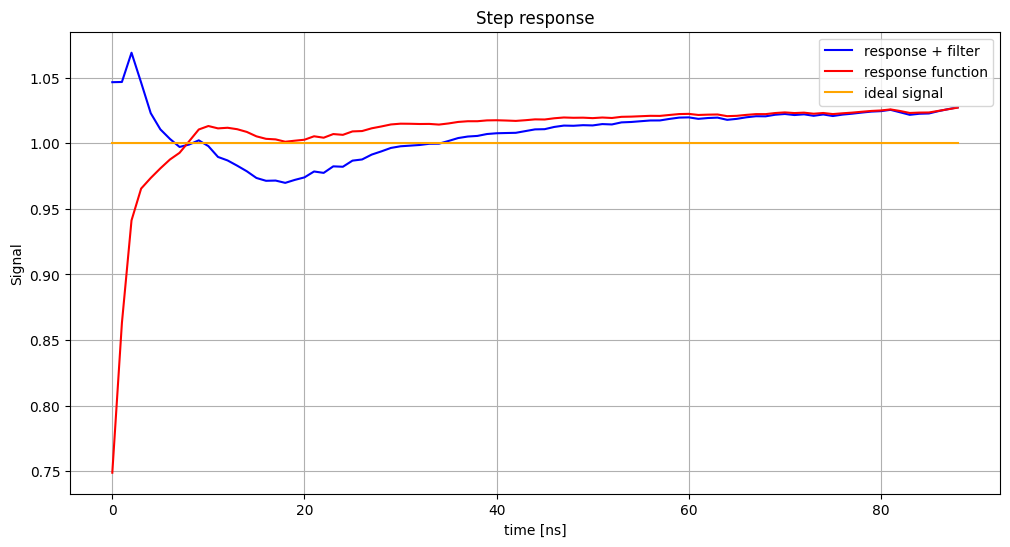

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(
    filtered_response,
    color="blue",
    label="response + filter",
)
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

In [50]:
zi = lfilter_zi(b_total, a_total) * step_response[0]
filtered_response, _ = lfilter(b_total, a_total, step_response, zi=zi)

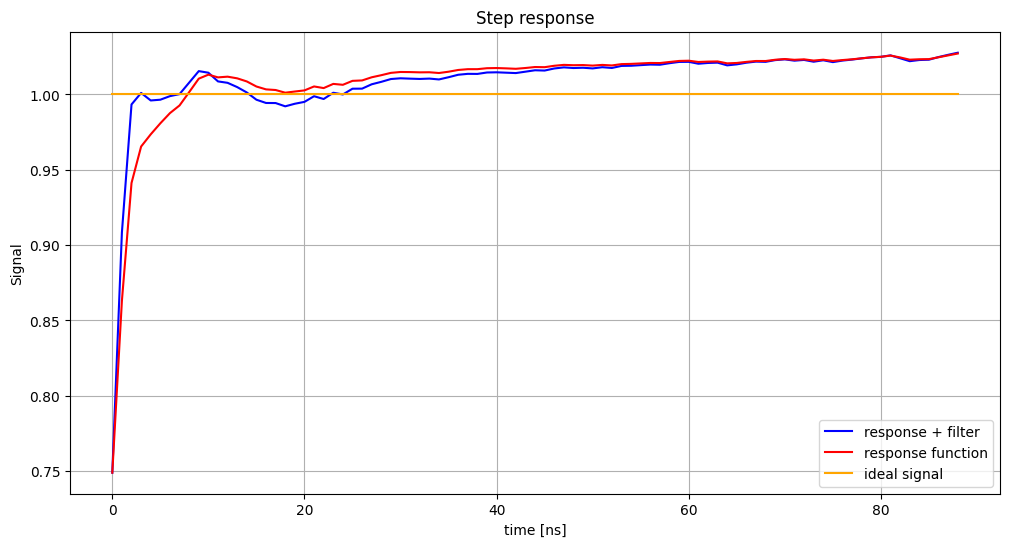

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(
    filtered_response,
    color="blue",
    label="response + filter",
)
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()